In [56]:
import networkx as nx
from networkx import DiGraph, MultiDiGraph
import osmnx as ox
from osmnx import convert
from pyrosm.data import sources, get_data
from pyrosm import OSM
import matplotlib.pyplot as plt
from edmonds_karp import find_maximum_flow_using_edmonds_karp, find_maximum_flow_using_edmonds_karp_multidigraph
from plot_route import plot_routes
import numpy as np
from numpy.random import RandomState
%matplotlib inline

In [57]:
print(sources.cities.available)
# vn = get_data("vietnam")
ox.settings.use_cache = True

raw_data_osm = OSM('raw.pbf')

# nodes, edges = raw_data_osm.get_network(nodes=True, network_type='driving')


['Aachen', 'Aarhus', 'Adelaide', 'Albuquerque', 'Alexandria', 'Amsterdam', 'Antwerpen', 'Arnhem', 'Auckland', 'Augsburg', 'Austin', 'Baghdad', 'Baku', 'Balaton', 'Bamberg', 'Bangkok', 'Barcelona', 'Basel', 'Beijing', 'Beirut', 'Berkeley', 'Berlin', 'Bern', 'Bielefeld', 'Birmingham', 'Bochum', 'Bogota', 'Bombay', 'Bonn', 'Bordeaux', 'Boulder', 'BrandenburgHavel', 'Braunschweig', 'Bremen', 'Bremerhaven', 'Brisbane', 'Bristol', 'Brno', 'Bruegge', 'Bruessel', 'Budapest', 'BuenosAires', 'Cairo', 'Calgary', 'Cambridge', 'CambridgeMa', 'Canberra', 'CapeTown', 'Chemnitz', 'Chicago', 'ClermontFerrand', 'Colmar', 'Copenhagen', 'Cork', 'Corsica', 'Corvallis', 'Cottbus', 'Cracow', 'CraterLake', 'Curitiba', 'Cusco', 'Dallas', 'Darmstadt', 'Davis', 'DenHaag', 'Denver', 'Dessau', 'Dortmund', 'Dresden', 'Dublin', 'Duesseldorf', 'Duisburg', 'Edinburgh', 'Eindhoven', 'Emden', 'Erfurt', 'Erlangen', 'Eugene', 'Flensburg', 'FortCollins', 'Frankfurt', 'FrankfurtOder', 'Freiburg', 'Gdansk', 'Genf', 'Gent', '

In [58]:
G = ox.graph_from_bbox(bbox=(10.81864,10.78786,106.71535,106.64738), network_type='drive', retain_all=True)
# G = raw_data_osm.to_graph(nodes=nodes, edges=edges, graph_type='networkx', retain_all=True, network_type='driving')

# Get largest strongly connected component
G = ox.truncate.largest_component(G, strongly=False)

# G = ox.simplification.simplify_graph(G)

G = ox.routing.add_edge_speeds(G)
M: MultiDiGraph = ox.routing.add_edge_travel_times(G)
G: DiGraph = ox.convert.to_digraph(G, weight='length')

capacity_rules = {
        'motorway': 2000,
        'trunk': 1800,
        'primary': 1600,
        'secondary': 1200,
        'tertiary': 800,
        'residential': 400,
        'unclassified': 300,
        'service': 200
    }

for u, v, k, data in M.edges(data=True, keys=True):
    highway_type = data.get('highway', 'unclassified')

    if isinstance(highway_type, list):
            highway_type = highway_type[0]

    base_capacity = capacity_rules.get(highway_type, 300)
    lanes = data.get('lanes', 1)
    if isinstance(lanes, list):
        lanes = float(lanes[0])
    else:
         lanes = float(lanes)
         
    speed = data.get('speed_kph', 30)
    travel_time = data.get('travel_time', 0)
    speed_factor = min(2.0, max(0.5, speed / 50))
    final_capacity = base_capacity * lanes * speed_factor
    M.edges[u,v, k]['capacity'] = final_capacity

for u, v, data in G.edges(data=True):
    highway_type = data.get('highway', 'unclassified')

    if isinstance(highway_type, list):
            highway_type = highway_type[0]

    base_capacity = capacity_rules.get(highway_type, 300)
    lanes = data.get('lanes', 1)
    if isinstance(lanes, list):
        lanes = float(lanes[0])
    else:
         lanes = float(lanes)
         
    speed = data.get('speed_kph', 30)
    travel_time = data.get('travel_time', 0)
    speed_factor = min(2.0, max(0.5, speed / 50))
    final_capacity = base_capacity * lanes * speed_factor
    data['capacity'] = final_capacity

/tmp/ipykernel_40554/1866470229.py:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(bbox=(10.81864,10.78786,106.71535,106.64738), network_type='drive', retain_all=True)


In [59]:
# for u, v, data in G.edges(data=True):
#     print(f'u: {u}')
#     print(f'v: {v}')
    # print(f'data: {data}')

In [60]:
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(M)



In [61]:
gdf_nodes

,y,x,street_count,highway,geometry
osmid,,,,,
366367322,10.799133,106.657162,3,NaN,POINT (106.65716 10.79913)
366367617,10.810271,106.666859,4,NaN,POINT (106.66686 10.81027)
366367996,10.790647,106.666654,3,NaN,POINT (106.66665 10.79065)
366368194,10.790241,106.709544,3,NaN,POINT (106.70954 10.79024)
366368733,10.796539,106.652559,3,crossing,POINT (106.65256 10.79654)
...,...,...,...,...,...
12183771640,10.799697,106.707710,1,NaN,POINT (106.70771 10.79970)
12234339842,10.790140,106.684728,3,NaN,POINT (106.68473 10.79014)
12295658876,10.793918,106.651928,3,NaN,POINT (106.65193 10.79392)


In [62]:
gdf_edges

osmid                     name  \
u           v           key                                                     
366367322   6257994043  0                  668267736  Hẻm 97 Nguyễn Thái Bình   
            11361818084 0                 1219459269         Nguyễn Thái Bình   
            6257994039  0                 1219459269         Nguyễn Thái Bình   
366367617   7940859504  0                   32581480                 Cửu Long   
            5755535162  0                   32584095                  Lam Sơn   
...                                              ...                      ...   
12295658876 12295658880 0                 1328977640                      NaN   
12295658880 11468812721 0                  138877181             Trường Chinh   
12298284084 10910534491 0                 1133351424     Hẻm 42 Ung Văn Khiêm   
            3631245428  0                 1133351424     Hẻm 42 Ung Văn Khiêm   
                        1    [358136776, 1329254965]     Hẻm 42 Ung Văn Khiêm   

                                  highway  oneway reversed   length  \
u           v           key                                           
366367322   6257994043  0     residential   False    False   49.471   
            11361818084 0        tertiary   False    False   91.724   
            6257994039  0        tertiary   False     True    6.287   
366367617   7940859504  0     residential   False     True   56.076   
            5755535162  0     residential   False    False   78.168   
...                                   ...     ...      ...      ...   
12295658876 12295658880 0    primary_link    True    False   34.350   
12295658880 11468812721 0         primary    True    False   73.410   
12298284084 10910534491 0     residential   False    False   63.525   
            3631245428  0     residential   False     True  186.349   
                        1     residential   False     True  218.997   

                                                                      geometry  \
u           v           key                                                      
366367322   6257994043  0    LINESTRING (106.65716 10.79913, 106.65716 10.7...   
            11361818084 0    LINESTRING (106.65716 10.79913, 106.65784 10.7...   
            6257994039  0    LINESTRING (106.65716 10.79913, 106.65714 10.7...   
366367617   7940859504  0    LINESTRING (106.66686 10.81027, 106.66734 10.8...   
            5755535162  0    LINESTRING (106.66686 10.81027, 106.66681 10.8...   
...                                                                        ...   
12295658876 12295658880 0    LINESTRING (106.65193 10.79392, 106.65192 10.7...   
12295658880 11468812721 0    LINESTRING (106.65200 10.79363, 106.65212 10.7...   
12298284084 10910534491 0    LINESTRING (106.71233 10.80713, 106.71226 10.8...   
            3631245428  0    LINESTRING (106.71233 10.80713, 106.71239 10.8...   
                        1    LINESTRING (106.71233 10.80713, 106.71241 10.8...   

                             speed_kph  travel_time  capacity lanes maxspeed  \
u           v           key                                                    
366367322   6257994043  0         46.5          3.8     372.0   NaN      NaN   
            11361818084 0         36.7          9.0     587.2   NaN      NaN   
            6257994039  0         36.7          0.6     587.2   NaN      NaN   
366367617   7940859504  0         46.5          4.3     372.0   NaN      NaN   
            5755535162  0         46.5          6.1     372.0   NaN      NaN   
...                                ...          ...       ...   ...      ...   
12295658876 12295658880 0         46.7          2.6     280.2   NaN      NaN   
12295658880 11468812721 0         53.4          4.9    1708.8   NaN      NaN   
12298284084 10910534491 0         46.5          4.9     372.0   NaN      NaN   
            3631245428  0         46.5         14.4     372.0   NaN      NaN   
                        1         46.5    

# Maximum flow

In [63]:
source = 2658956868
sink = 3463112613
gdf_nodes.sample(n=2, random_state=np.random.Generator())

TypeError: __init__() takes exactly 1 positional argument (0 given)

In [ ]:
max_value, flow_dict = nx.maximum_flow(G, source, sink,  capacity='capacity')

print(f'Expected max value: {max_value}, len: {len(flow_dict)}')
# for u in flow_dict:
#     print(f'flow: {u}, val: {flow_dict[u]}')
#     for v, f in flow_dict[u].items():
#         if f > 0:
#             print(f'u: {u}, v: {v}, flow: {f}')

Expected max value: 372.0, len: 3316


In [ ]:
route_color = "#4cd137"

# Edmonds Karp

max flow: 372.0
len all routes: 2
all_routes: [[2658956868, 411923637, 411926363, 411918842, 411920821, 411925870, 411922945, 411925966, 2332682130, 2366457792, 6729387208, 3734437558, 6729387214, 2291062340, 4426095095, 1671468479, 711335740, 3717158280, 3638268672, 366453218, 2214251893, 11959710135, 710021199, 6349850088, 710021190, 6349849903, 8819977394, 9404173935, 9404173934, 6354514377, 366465907, 2300355924, 366448695, 727568351, 860695661, 366382100, 3463112599, 5778872979, 5769486900, 5769486901, 3463111582, 9202600501, 3463111590, 3463112648, 3463112614, 3463112613], [2658956868, 411923637, 411926363, 411918842, 411920821, 411925870, 411922945, 411925966, 2332682130, 2366457792, 6729387208, 3734437558, 6729387214, 2291062340, 4426095095, 1671468479, 711335740, 3717158280, 3638268672, 366453218, 2214251893, 11959710135, 2431839590, 6349850096, 9404173931, 9404173930, 710021187, 4191224556, 710021186, 6356490314, 6356490310, 2164847259, 710021175, 7870856469, 860695661, 36638

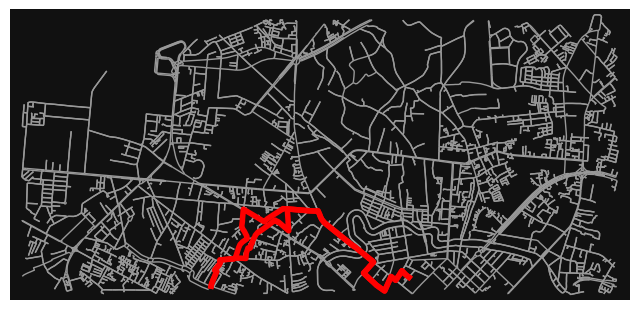

In [ ]:

max_flow, all_routes = find_maximum_flow_using_edmonds_karp(G, source, sink)
print(f'max flow: {max_flow}')
print(f'len all routes: {len(all_routes)}')
print(f'all_routes: {all_routes}')
fig, ax = plot_routes(M, routes=all_routes, node_size=0, route_linewidth=1,route_alpha=1,  orig_dest_size=4,route_color=route_color)

# Edmond Karps MultiDiGraph

max flow: 372.0
len routes: 2
all_routes: [[2658956868, 411923637, 411926363, 411918842, 411920821, 411925870, 411922945, 411925966, 2332682130, 2366457792, 6729387208, 3734437558, 6729387214, 2291062340, 4426095095, 1671468479, 711335740, 3717158280, 3638268672, 366453218, 2214251893, 11959710135, 710021199, 6349850088, 710021190, 6349849903, 8819977394, 9404173935, 9404173934, 6354514377, 366465907, 2300355924, 366448695, 727568351, 860695661, 366382100, 3463112599, 5778872979, 5769486900, 5769486901, 3463111582, 9202600501, 3463111590, 3463112648, 3463112614, 3463112613], [2658956868, 411923637, 411926363, 411918842, 411920821, 411925870, 411922945, 411925966, 2332682130, 2366457792, 6729387208, 3734437558, 6729387214, 2291062340, 4426095095, 1671468479, 711335740, 3717158280, 3638268672, 366453218, 2214251893, 11959710135, 2431839590, 6349850096, 9404173931, 9404173930, 710021187, 4191224556, 710021186, 6356490314, 6356490310, 2164847259, 710021175, 7870856469, 860695661, 366382100

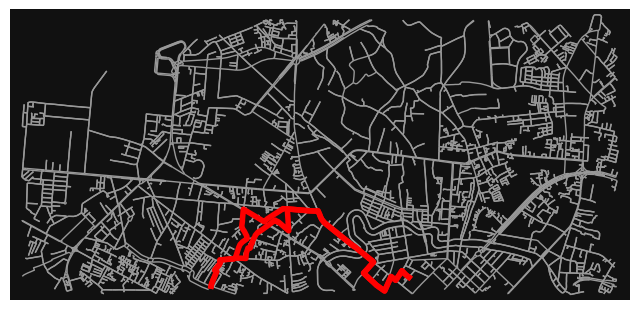

draw route, route: [2658956868, 411923637, 411926363, 411918842, 411920821, 411925870, 411922945, 411925966, 2332682130, 2366457792, 6729387208, 3734437558, 6729387214, 2291062340, 4426095095, 1671468479, 711335740, 3717158280, 3638268672, 366453218, 2214251893, 11959710135, 710021199, 6349850088, 710021190, 6349849903, 8819977394, 9404173935, 9404173934, 6354514377, 366465907, 2300355924, 366448695, 727568351, 860695661, 366382100, 3463112599, 5778872979, 5769486900, 5769486901, 3463111582, 9202600501, 3463111590, 3463112648, 3463112614, 3463112613]


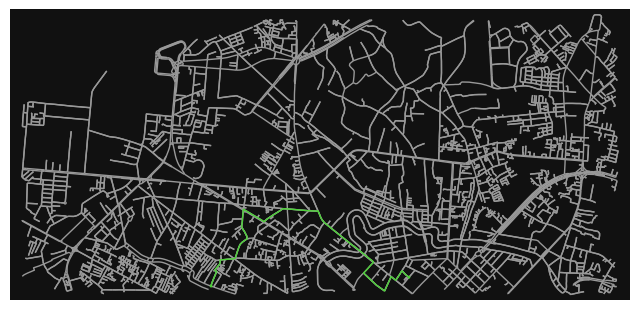

draw route, route: [2658956868, 411923637, 411926363, 411918842, 411920821, 411925870, 411922945, 411925966, 2332682130, 2366457792, 6729387208, 3734437558, 6729387214, 2291062340, 4426095095, 1671468479, 711335740, 3717158280, 3638268672, 366453218, 2214251893, 11959710135, 2431839590, 6349850096, 9404173931, 9404173930, 710021187, 4191224556, 710021186, 6356490314, 6356490310, 2164847259, 710021175, 7870856469, 860695661, 366382100, 3463112599, 5778872979, 5769486900, 5769486901, 3463111582, 9202600501, 3463111590, 3463112648, 3463112614, 3463112613]


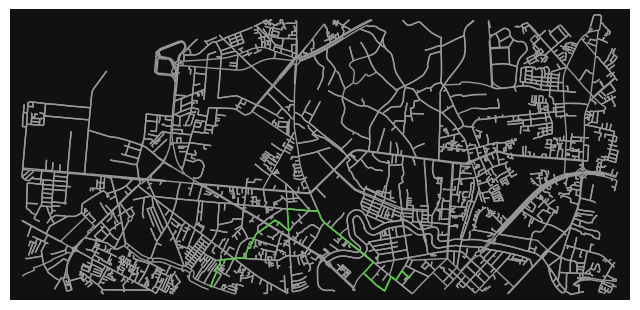

(2658956868, 2658956868)
(411923637, 411923637)
(411926363, 411926363)
(411918842, 411918842)
(411920821, 411920821)
(411925870, 411925870)
(411922945, 411922945)
(411925966, 411925966)
(2332682130, 2332682130)
(2366457792, 2366457792)
(6729387208, 6729387208)
(3734437558, 3734437558)
(6729387214, 6729387214)
(2291062340, 2291062340)
(4426095095, 4426095095)
(1671468479, 1671468479)
(711335740, 711335740)
(3717158280, 3717158280)
(3638268672, 3638268672)
(366453218, 366453218)
(2214251893, 2214251893)
(11959710135, 11959710135)
(710021199, 2431839590)
node khac nhau, (710021199, 2431839590)
(6349850088, 6349850096)
node khac nhau, (6349850088, 6349850096)
(710021190, 9404173931)
node khac nhau, (710021190, 9404173931)
(6349849903, 9404173930)
node khac nhau, (6349849903, 9404173930)
(8819977394, 710021187)
node khac nhau, (8819977394, 710021187)
(9404173935, 4191224556)
node khac nhau, (9404173935, 4191224556)
(9404173934, 710021186)
node khac nhau, (9404173934, 710021186)
(6354514377,

In [ ]:
max_flow, all_routes = find_maximum_flow_using_edmonds_karp_multidigraph(M, source, sink)
print(f'max flow: {max_flow}')
print(f'len routes: {len(all_routes)}')
print(f'all_routes: {all_routes}')
fig, ax = plot_routes(M, routes=all_routes, node_size=0, route_linewidth=1, route_alpha=1, orig_dest_size=4, route_color=route_color)
for route in all_routes:
    print(f'draw route, route: {route}')
    plot_routes(M, routes=[route], node_size=0, route_linewidth=1,route_alpha=1, orig_dest_size=4, route_color=route_color)
    
for pair in zip(all_routes[0], all_routes[1]):
    print(pair)
    if pair[0] != pair[1]:
        print(f'node khac nhau, {pair}')

# Plot graph

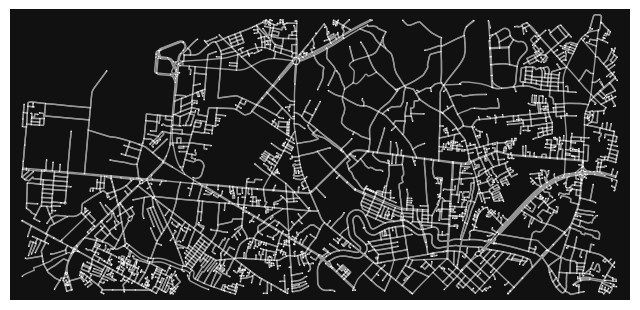

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.plot.plot_graph(M, save=True, show=True, filepath='./graph.png', node_size=1)
# nx.draw(G)
# plt.savefig('graph.png', bbox_inches='tight')